In [1]:
# Standard Python modules
import os, sys
import yaml
import glob
import numpy as np
import pandas as pd
import xarray as xr
import xoak

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline

# import personal modules
# Path to modules
sys.path.append('../../modules')
from ar_funcs import AR_rank
from wrf_preprocess import preprocess_2Dvar
import nclcmaps as nclc
from plotter import draw_basemap

In [2]:
# Set up paths
server = 'skyriver'
if server == 'skyriver':
    path_to_data = '/home/dnash/comet_data/'
    path_to_wrf = path_to_data + 'downloads/wrf-AK/'
elif server == 'comet':
    path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
    path_to_work = '/cw3e/mead/projects/cwp140/scratch/dnash/data/preprocessed/SEAK-WRF-precip/'
    path_to_wrf = path_to_data + 'downloads/SEAK-WRF/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
### TODO: make a yaml dict
ext1 = [-141., -130., 54., 61.] # extent of SEAK 
ext2 = [-150., -129., 53, 62]

## six communities
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.8894, 59.3988, Klukwan
# -139.671	59.5121, Yakutat (PAYA)
# -133.1358, 55.4769, Craig
# -132.4009, 55.5400, Kasaan

xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
lbl_align = ['center', 'left', 'right', 'center', 'right', 'center'] # where the labels go

## closest station
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.5117	59.2429, Haines (PAHN)
# -139.671	59.5121, Yakutat (PAYA)
# -133.076	55.5792, Klawock (PAKW)
# -131.7117	55.3567, Ketchikan (PAKT)
xs2 = [-135.4519, -135.3277, -135.5117, -139.671, -133.076, -131.7117]
ys2 = [58.1122, 59.4538, 59.2429, 59.5121, 55.5792, 55.3567]
lbl2 = ['PAOH', 'PAGY', 'PAHN', 'PAYA', 'PAKW', 'PAKT']

In [4]:
for i, (slon, slat) in enumerate(zip(xs, ys)):
    print(slon, slat)

-135.4519 58.1122
-135.3277 59.4538
-135.8894 59.3988
-139.671 59.5121
-133.1358 55.4769
-132.4009 55.54


### Import preprocessed WRF data

In [5]:
# %%time
# # get list of filenames that contain data from that year from current year folder
# year = '1992'
# varname = 'PCPT'
# filenames = []
# for name in glob.glob(path_to_data + 'preprocessed/SEAK-WRF-{0}/WRFDS_{0}_{1}.nc'.format(varname, year)):
#     filenames.append(name)
# # sort filenames so they are in chronological order
# filenames = sorted(filenames)
# print(filenames)
# wrf = xr.open_mfdataset(filenames, combine='by_coords')

# # wrf = preprocess_PCPT_test(filenames)
# # wrf = preprocess_2Dvar(filenames, output_varname)
# # wrf = preprocess_PCPT(filenames)
# # wrf = preprocess_2Dvar_new(filenames, output_varname)


# # wrf

In [6]:
year = '1992'
varname = 'PCPT'
fname = path_to_data + 'preprocessed/SEAK-WRF-{0}/WRFDS_{0}_{1}.nc'.format(varname, year)
print(fname)

/home/dnash/comet_data/preprocessed/SEAK-WRF-PCPT/WRFDS_PCPT_1992.nc


In [7]:
wrf = xr.open_dataset(fname)
wrf = wrf.resample(time="1D").sum('time')
wrf

<xarray.Dataset>
Dimensions:  (time: 366, y: 250, x: 320)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1992-01-02 ... 1992-12-31
    lat      (y, x) float32 53.12 53.12 53.13 53.13 ... 61.97 61.97 61.96 61.95
    lon      (y, x) float32 -148.1 -148.0 -147.9 -147.9 ... -126.4 -126.3 -126.3
Dimensions without coordinates: y, x
Data variables:
    PCPT     (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    contact:  rtladerjr@alaska.edu
    info:     Alaska CASC
    data:     Downscaled CFSR
    format:   version 1
    date:     Thu Jan 31 22:12:52 AKST 2019

In [8]:
slon = -135.8894
slat = 59.3988
## select nearest grid cell to station
points = xr.Dataset({"lat": slat, "lon": slon})
wrf.xoak.set_index(["lat", "lon"], "sklearn_geo_balltree")
ds = wrf.xoak.sel(lat=points.lat, lon=points.lon)

In [9]:
z = ds.PCPT.to_dataframe().PCPT.values

In [12]:
option='a'
temporal_res='daily'
fname = '../../out/SEAK_precip_max_{0}_{1}_old.csv'.format(option, temporal_res)
prec_df = pd.read_csv(fname)
prec_df = prec_df.set_index(pd.to_datetime(prec_df['time'], format='%Y-%m-%d %H:%M:%S')) # reset the index as "date"

idx = (prec_df.index.year == 1992)
prec_df = prec_df.loc[idx]
prec_df

,time,Hoonah,Skagway,Klukwan,Yakutat,Craig,Kasaan
time,,,,,,,
1992-01-01,1992-01-01,11.486328,15.712891,11.917969,16.664062,24.439453,29.466797
1992-01-02,1992-01-02,6.232422,6.916016,1.243164,15.390625,2.130859,9.943359
1992-01-03,1992-01-03,9.408203,4.005859,8.646484,6.144531,2.052734,1.474609
1992-01-04,1992-01-04,3.435547,0.638672,2.397461,13.468750,1.396484,2.650391
1992-01-05,1992-01-05,3.587891,0.634766,2.378906,0.410156,4.654297,0.572266
...,...,...,...,...,...,...,...
1992-12-27,1992-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1992-12-28,1992-12-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1992-12-29,1992-12-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
x = prec_df.time.values
y = prec_df.Klukwan.values

In [14]:
xticks = range(0, len(x))

x_lbl = []
for j in range(len(x)):
    t = pd.to_datetime(str(x[j]))
    x_lbl.append(t.strftime('%m-%d'))

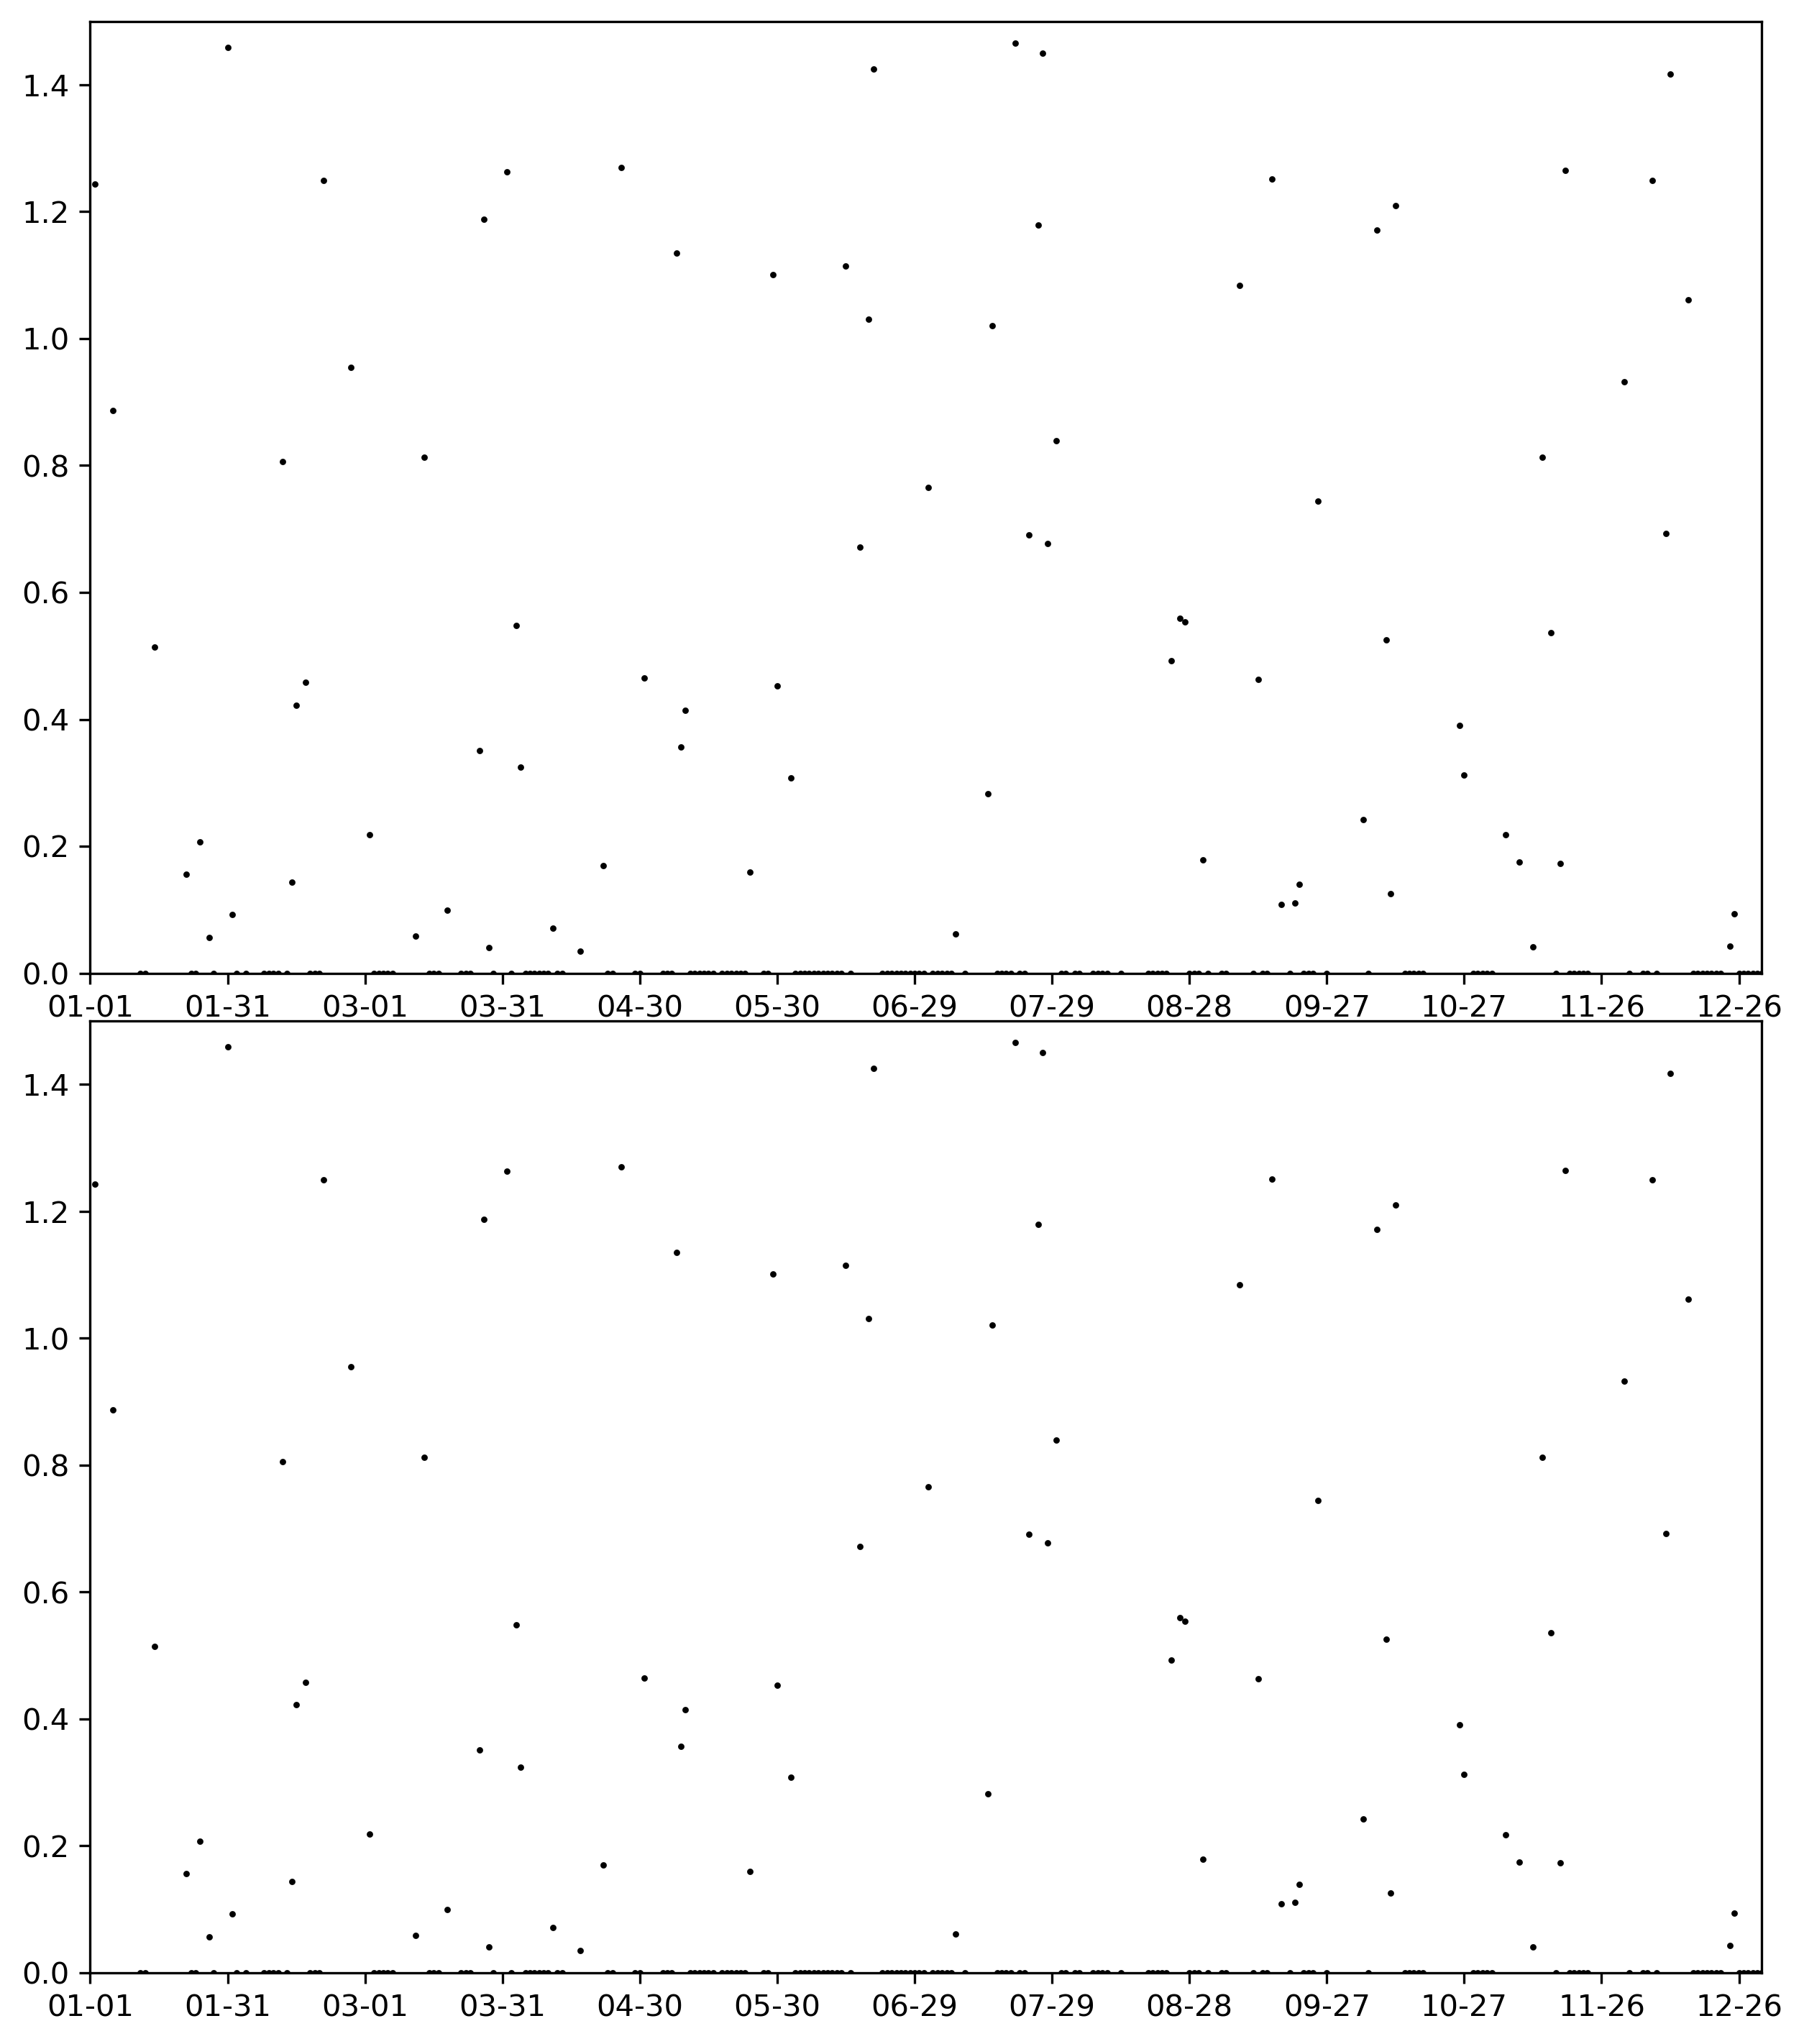

In [15]:
from matplotlib.gridspec import GridSpec
# Create figure
fig = plt.figure(figsize=(10, 11.75))
fig.dpi = 300
fname = path_to_figs + 'WRF_artifact_test'
fmt = 'png'

nrows = 2
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1], width_ratios = [1], wspace=0.05, hspace=0.05)
## use gs[rows index, columns index] to access grids

ax = fig.add_subplot(gs[0, 0])
ax.scatter(x, y, s=5, c='k', marker='.')
ax.set_ylim(0, 1.5)
dt = 30
ax.set_xticks(xticks[::dt]) # set the labels every 15 days
ax.set_xticklabels(x_lbl[::dt], fontsize=10)
ax.set_xlim(x.min(), x.max())

ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(x, z, s=5, c='k', marker='.')
ax2.set_ylim(0, 1.5)
ax2.set_xticks(xticks[::dt]) # set the labels every 15 days
ax2.set_xticklabels(x_lbl[::dt], fontsize=10)
ax2.set_xlim(x.min(), x.max())

plt.show()